# Learning to Rank

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [126]:
import numpy as np
import pandas as pd
import cvxpy as cp
import quantstats as qs
from tqdm import tqdm
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from qs import calc_factor, calc_return
from pypfopt.efficient_frontier import EfficientFrontier
from xgboost import XGBRanker, XGBRegressor
%config InlineBackend.figure_format = "retina"

In [92]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(
        self,
        n_splits=3,
        train_period_length=12,
        test_period_length=12,
        lookahead=0,
        date_idx="date",
        shuffle=False,
    ):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append(
                [train_start_idx, train_end_idx, test_start_idx, test_end_idx]
            )

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[
                (dates[self.date_idx] > days[train_start])
                & (dates[self.date_idx] <= days[train_end])
            ].index
            test_idx = dates[
                (dates[self.date_idx] > days[test_start])
                & (dates[self.date_idx] <= days[test_end])
            ].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self):
        return self.n_splits

def get_train_valid(X, y, train_idx, val_idx):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    return X_train, y_train, X_val, y_val

def cross_validation(reg):
    r2_ = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
        X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        r2 = r2_score(y_val, y_pred)
        r2_.append(r2)
        print(f"fold: {fold}, r2: {r2}")
    print(f"Avg. r2: {np.mean(r2_)}")

In [93]:
def combine_factor(freq, **kwargs):
    factor = pd.DataFrame(
        {name: factor.resample(freq).last().stack() for name, factor in kwargs.items()}
    )
    return factor

def calc_factor(crsp, famafrench, mfis, glb, freq):
    from statsmodels.regression.rolling import RollingOLS
    from sklearn.preprocessing import quantile_transform
    
    # Estimate factor exposure
    portfolio = crsp.loc[crsp.date >= "1994-01-01", :].pivot(
        index="date", columns="permno", values="ret"
    )
    portfolio = portfolio.sub(famafrench.loc[portfolio.index, "rf"], axis=0)
    factor = famafrench.loc[portfolio.index, ["mktrf", "smb", "hml", "mom"]].assign(
        alpha=1
    )
    betas = []
    for permno in portfolio:
        ret = portfolio[permno]
        res = RollingOLS(endog=ret, exog=factor, window=756).fit(params_only=True)
        params = res.params
        params["resid"] = ret - factor.mul(params).sum(1)
        params["permno"] = permno
        betas.append(params)
    beta = pd.concat(betas).reset_index().dropna()

    # Pivot data for calculation
    ret = crsp.pivot(index="date", columns="permno", values="ret").sub(
        famafrench.rf, axis=0
    )
    logret = np.log(ret + 1)
    shrout = crsp.pivot(index="date", columns="permno", values="shrout")
    vol = crsp.pivot(index="date", columns="permno", values="volume")
    close = crsp.pivot(index="date", columns="permno", values="close")
    dv = vol.mul(close)
    mktrf = beta.pivot(index="date", columns="permno", values="mktrf")
    resid = beta.pivot(index="date", columns="permno", values="resid")

    # Estimate price trend
    # 1-month cumulative return
    mom_1m = logret.rolling(21).sum()
    # 11-month cumulative returns ending 1-month before
    mom_12m = logret.shift(21).rolling(11 * 21).sum()
    # Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
    mom_6m = logret.shift(21).rolling(5 * 21).sum()
    mom_12m_6m = logret.shift(6 * 21).rolling(5 * 21).sum()
    chmom = mom_6m - mom_12m_6m
    # Max daily returns from calendar month t-1
    maxret = logret.rolling(21).max()
    # Cumulative returns months t-36 to t-13
    mom_36m = logret.shift(12 * 21).rolling(24 * 21).sum()

    # Estimate liquidity
    # Average monthly trading volume for most recent three months divided by number of shares
    turn = vol.shift(21).mean().div(shrout)
    # Monthly std dev of daily share turnover
    turn_std = vol.div(shrout).rolling(21).std()
    # Natural log of market cap
    logcap = np.log(close) + np.log(shrout)
    # Natural log of trading volume times price per share from month t-2
    dolvol = np.log(dv.shift(21).rolling(21).mean())
    # Average of daily (absolute return / dollar volume)
    ill = ret.abs().div(dv)

    # Estimate risk
    # Standard dev of daily returns from month t-1
    retvol = ret.rolling(21).std()
    # Market beta squared
    mktrf_sq = mktrf.pow(2)
    # Idiosyncratic return volatility
    idovol = resid.rolling(756).std()

    # Combine factors to the required frequency
    factor = combine_factor(
        freq,
        mom_1m=mom_1m,
        mom_12m=mom_12m,
        chmom=chmom,
        maxret=maxret,
        mom_36m=mom_36m,
        turn=turn,
        turn_std=turn_std,
        logcap=logcap,
        dolvol=dolvol,
        ill=ill,
        retvol=retvol,
        mktrf_sq=mktrf_sq,
        idovol=idovol,
    )
    if freq == "D":
        beta_ = beta.set_index(["date", "permno"])
        mfis_ = mfis.set_index(["date", "permno"])
        glb_ = glb.set_index(["date", "permno"])
    else:
        beta_ = beta.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
        mfis_ = mfis.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
        glb_ = glb.groupby([pd.Grouper(key="date", freq=freq), "permno"]).last()
    factor = factor.join(beta_).join(mfis_).join(glb_)
    # Fill missing value with cross sectional median
    factor = factor.groupby("date").transform(lambda x: x.fillna(x.median())).dropna()
    return factor

In [94]:
crsp = pd.read_parquet("./data/crsp.parquet")
glb = pd.read_parquet("./data/glb.parquet")
mfis = pd.read_parquet("./data/mfis.parquet")
famafrench = pd.read_parquet("./data/famafrench.parquet")
optionmetrics = pd.read_parquet("./data/optionmetrics.parquet")
crsp["w_cap"] = (crsp.close * crsp.shrout).groupby(crsp.date).apply(lambda x: x / x.sum())

In [127]:
factor = calc_factor(crsp, famafrench, mfis, glb, "D")
ret = calc_return(crsp, famafrench, "D")
rank = ret.groupby("date").rank(method="dense", )
y_train = rank["2000-01-01":"2008-12-31"].groupby("permno").shift(-1).dropna()
X_train = factor.loc[y_train.index, :]
y_valid = ret["2008-12-01":"2012-12-31"].groupby("permno").shift(-1).dropna()
X_valid = factor.loc[y_valid.index, :]
ranker = XGBRanker(
    booster="gbtree",
    objective="rank:pairwise",
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=100,
    subsample=0.75,
)
# ranker.fit(X_train, y_train, group=y_train.groupby("date").size().to_numpy(), verbose=True)

XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.9,
             enable_categorical=False, eta=0.05, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.75, tree_method=None,
             validate_parameters=None, verbosity=None)

In [133]:
y_train = ret["2000-01-01":"2008-12-31"].groupby("permno").shift(-1).dropna()
X_train = factor.loc[y_train.index, :].drop(columns=["maxret", "logcap", "dolvol", "retvol", "mktrf_sq", "smb", "hml", "mfis_182"])
y_valid = ret["2008-12-01":"2012-12-31"].groupby("permno").shift(-1).dropna()
X_valid = factor.loc[y_valid.index, :].drop(columns=["maxret", "logcap", "dolvol", "retvol", "mktrf_sq", "smb", "hml", "mfis_182"])

reg = XGBRegressor(booster="gbtree",
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=100,
    subsample=0.75,)

reg.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             eta=0.05, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
spearman_ = []
for date in y_valid.index.get_level_values("date").unique():
    y_group = y_valid[date]
    X_group = X_valid.loc[date, :]
    y_pred = reg.predict(X_group)
    spearman = spearmanr(y_pred, y_group).correlation
    spearman_.append(spearman)
print(np.mean(spearman_))

0.02235621097046437


## Backtest

In [135]:
X = factor["2000-01-01":"2019-11-30"]
y = ret.groupby("permno").shift(-1).loc["2000-01-01":"2019-11-30"]
reg = XGBRegressor(booster="gbtree",
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=100,
    subsample=0.75)

In [136]:
cv = MultipleTimeSeriesCV(n_splits=7,
                          train_period_length=6*252,
                          test_period_length=252,
                          lookahead=1)

In [137]:
predictions = []
for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train, y_train, X_val, y_val = get_train_valid(X, y, train_idx, val_idx)
    y_train = y_train.groupby("date").rank(method="dense")
    ranker.fit(X_train, y_train, group=y_train.groupby("date").size().to_numpy())
    predictions.append(pd.Series(ranker.predict(X_val).reshape(-1), index=y_val.index))
y_pred = pd.concat(predictions).sort_index()

In [138]:
def calc_w():
    w_optimal = pd.Series(None, index=y_pred.index, dtype="float")
    w_caps = crsp.pivot(index="date", columns="permno", values="w_cap")
    unique_dates = y_pred.index.get_level_values("date").unique()
    for date in tqdm(unique_dates):
        mu = y_pred[date].to_numpy()
        Sigma = crsp[crsp.date <= date].pivot(index="date", columns="permno", values="ret").tail(252).cov().to_numpy()
        w_cap = w_caps.loc[date, :].to_numpy()
        ef = EfficientFrontier(mu, Sigma)
        ef.add_constraint(lambda x : x <= w_cap * 1.1)
        ef.add_constraint(lambda x : x >= w_cap * 0.9)
        w = ef.efficient_risk(target_volatility=1)
        w_optimal[date] = pd.Series(w)
    return w_optimal

In [139]:
bt = crsp.set_index(["date", "permno"]).loc["2013-01-01":"2019-12-31", ["ret", "w_cap"]]
bt["w_optimal"] = calc_w()
bt["w_optimal"] = bt.groupby("permno").w_optimal.transform(lambda x: x.fillna(method="ffill").shift(1))
bt = bt.dropna()

100%|██████████| 1764/1764 [01:33<00:00, 18.89it/s]


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-01-03  2013-01-03
End Period                 2019-12-31  2019-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          144.02%     139.2%
CAGR﹪                     13.6%       13.28%

Sharpe                     1.23        1.21
Smart Sharpe               1.19        1.16
Sortino                    1.76        1.72
Smart Sortino              1.7         1.66
Sortino/√2                 1.25        1.22
Smart Sortino/√2           1.2         1.17
Omega                      1.24        1.24

Max Drawdown               -12.92%     -13.02%
Longest DD Days            411         412
Volatility (ann.)          10.83%      10.84%
R^2                        1.0         1.0
Calmar                     1.05        1.02
Skew                       -0.44       -0.45
Kurtosis                   2.95        2

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-01-23,2015-08-25,2016-03-09,411,-12.919063,-11.617174
2,2018-12-03,2018-12-24,2019-02-22,81,-11.120084,-9.004778
3,2018-01-29,2018-05-02,2018-09-13,227,-10.063848,-9.814686
4,2013-05-16,2013-06-20,2013-07-12,57,-5.839231,-4.979242
5,2018-09-24,2018-10-11,2018-11-06,43,-5.522622,-4.973149


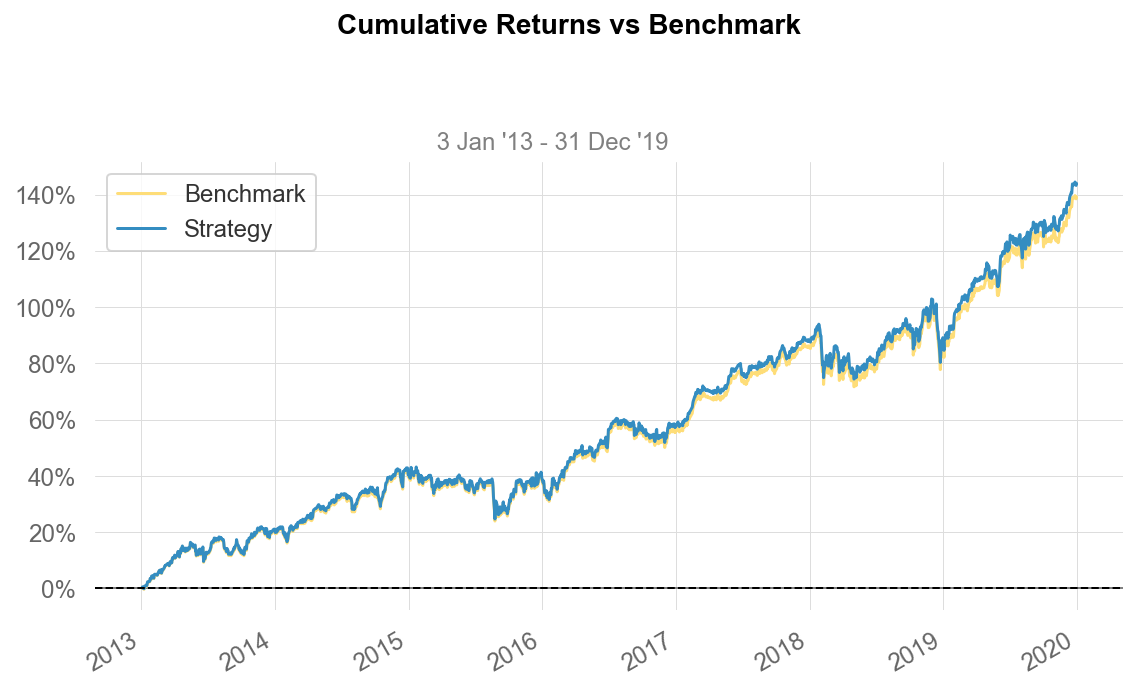

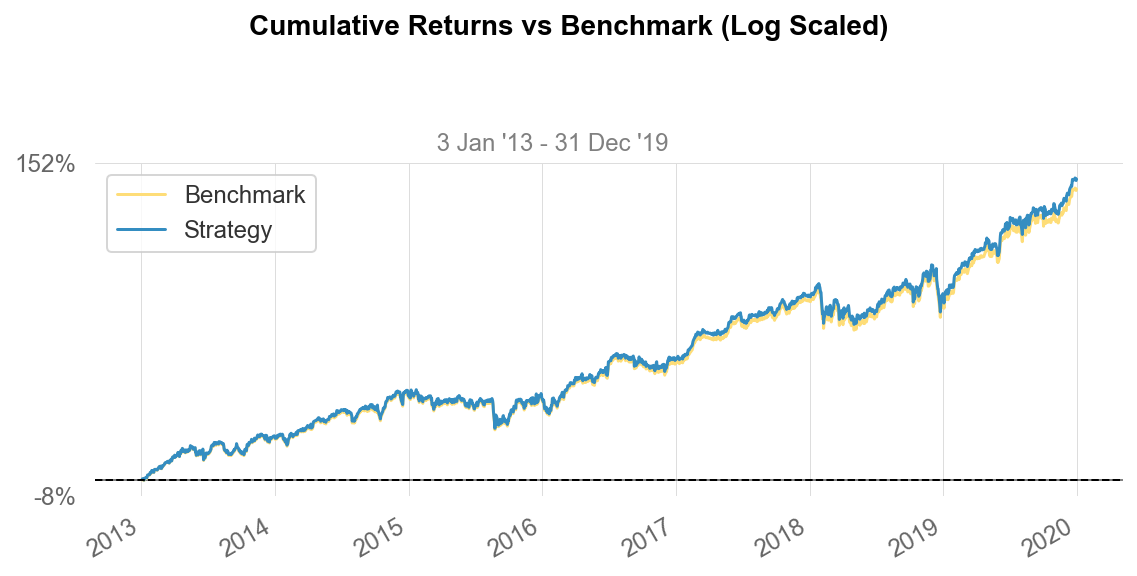

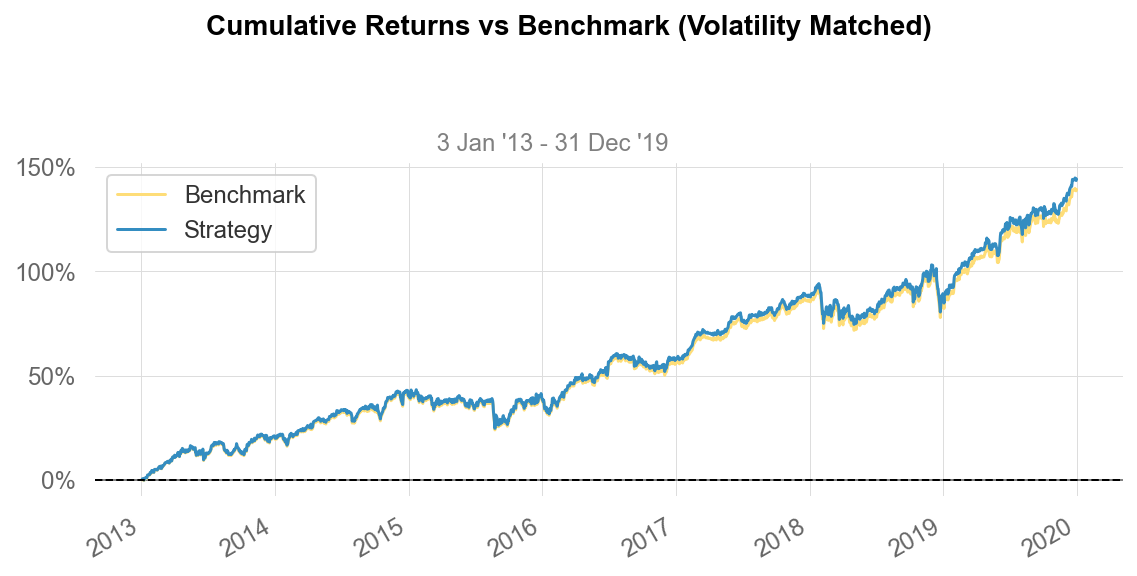

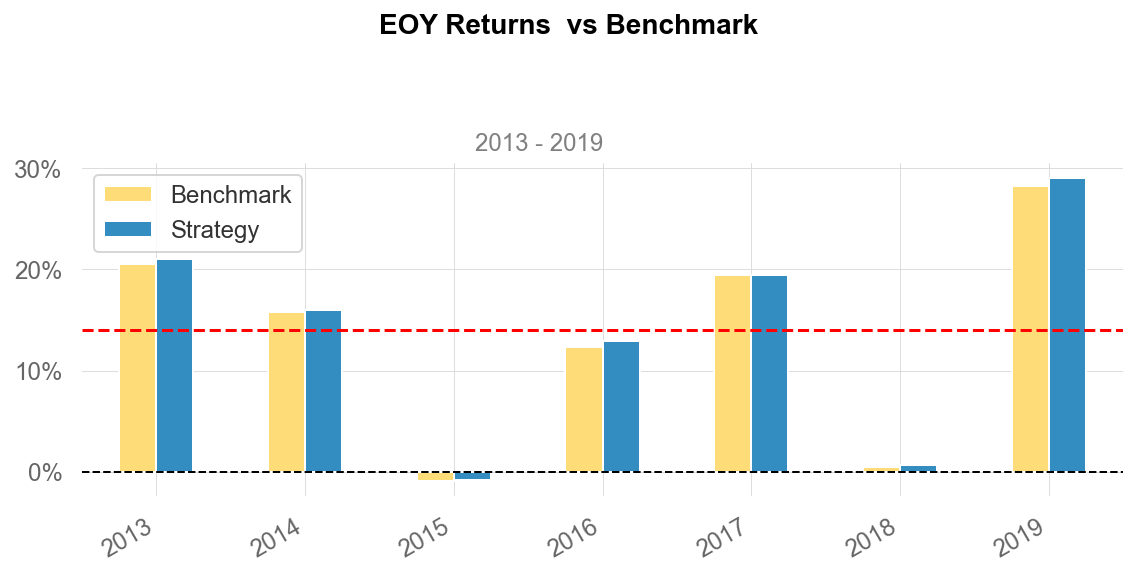

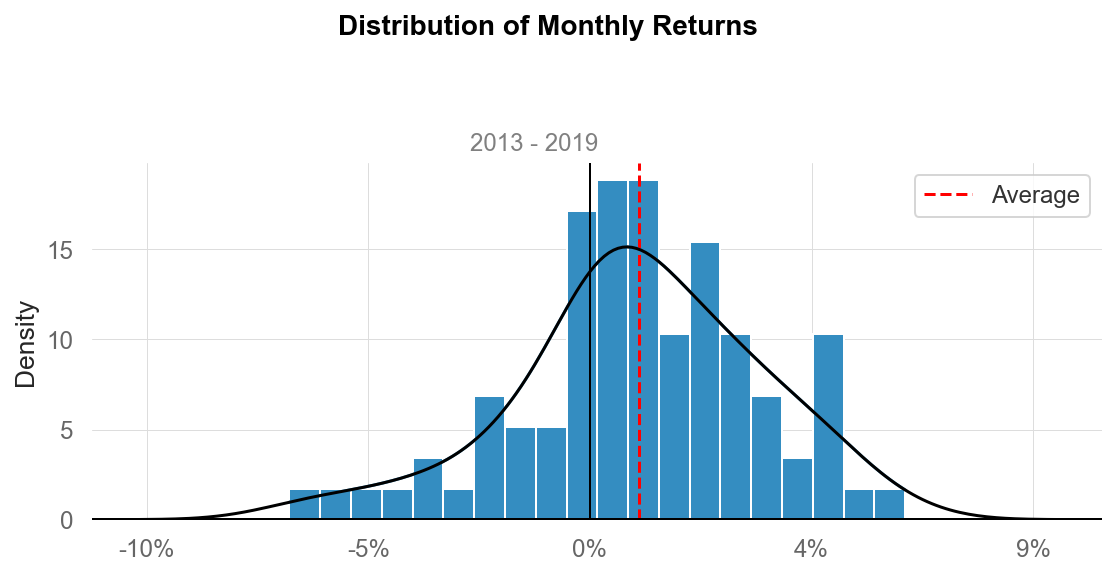

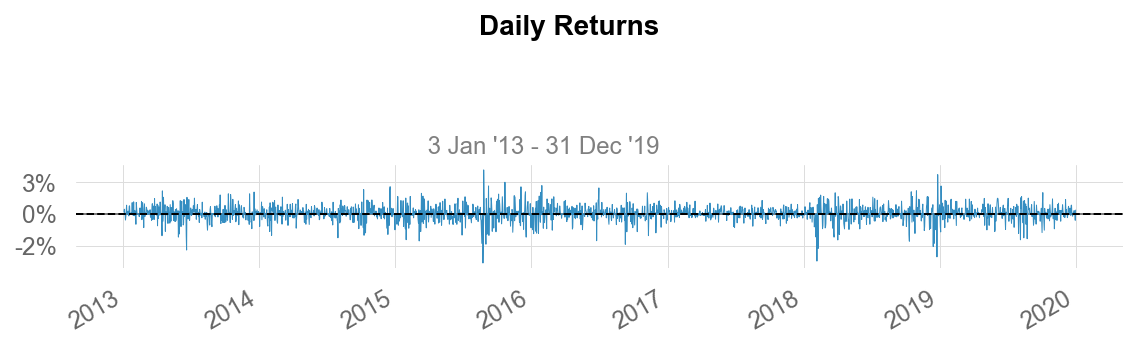

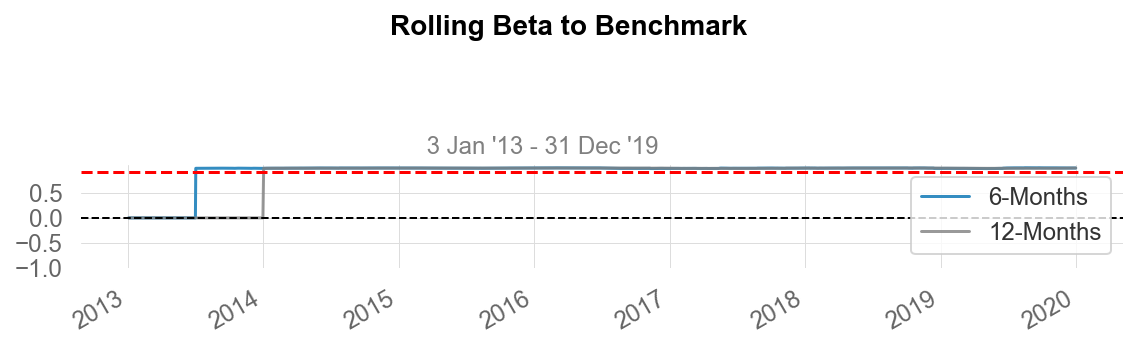

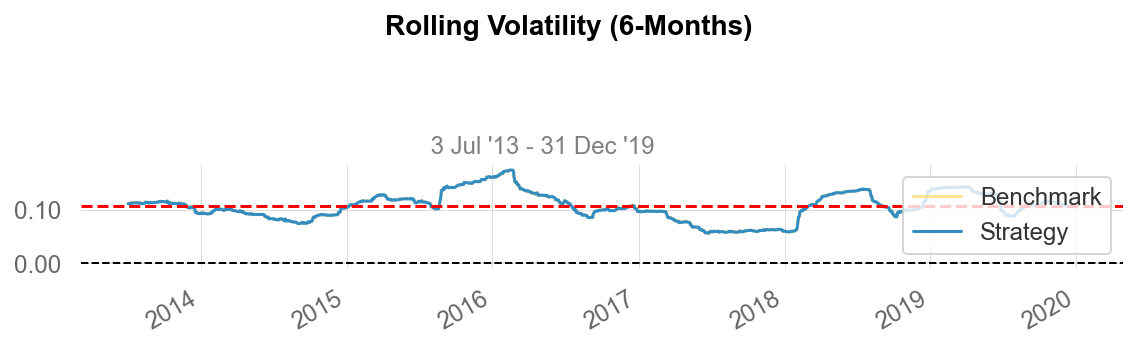

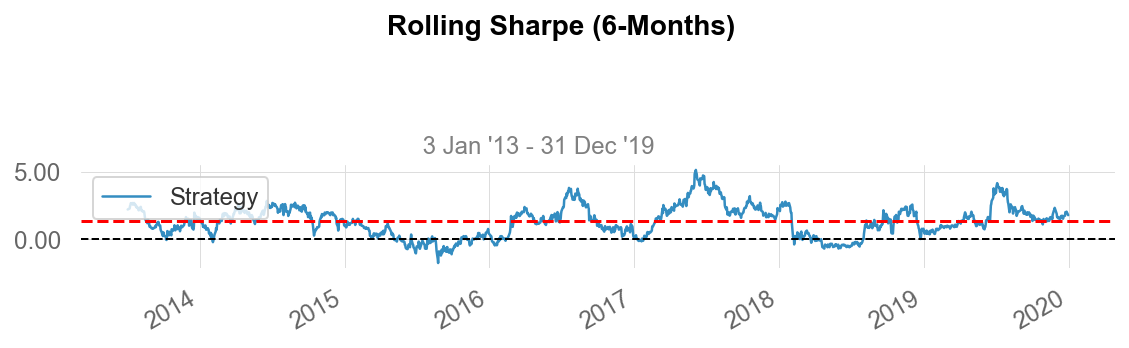

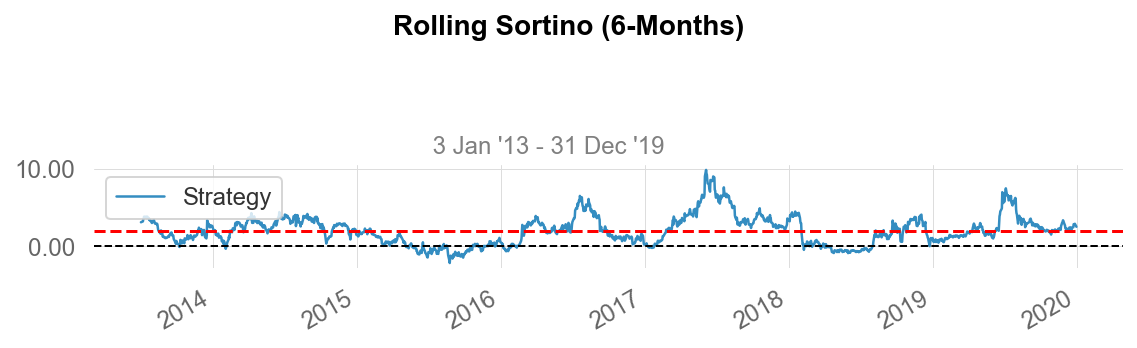

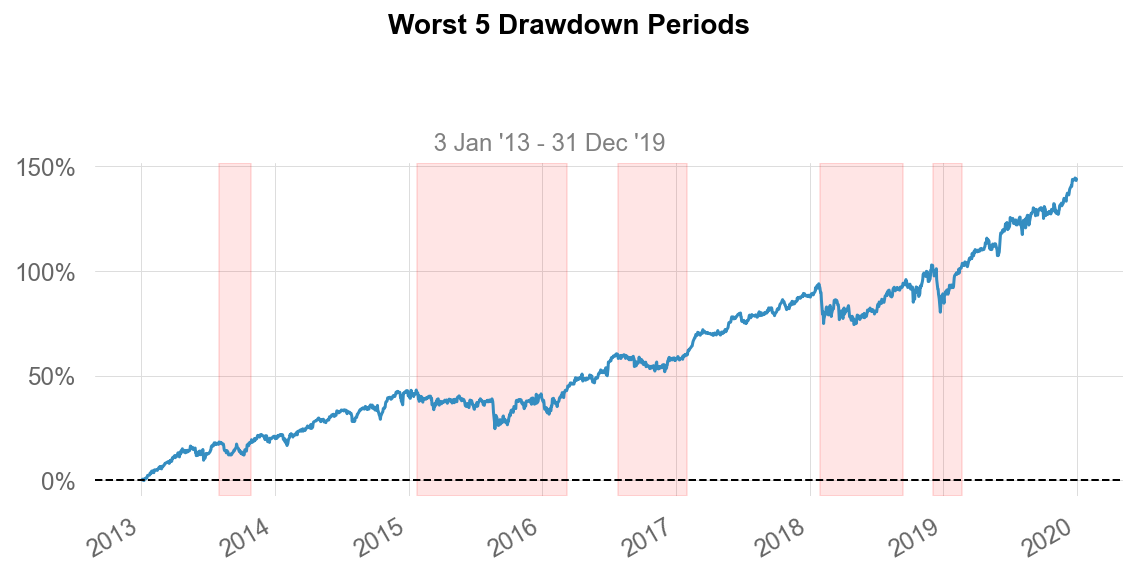

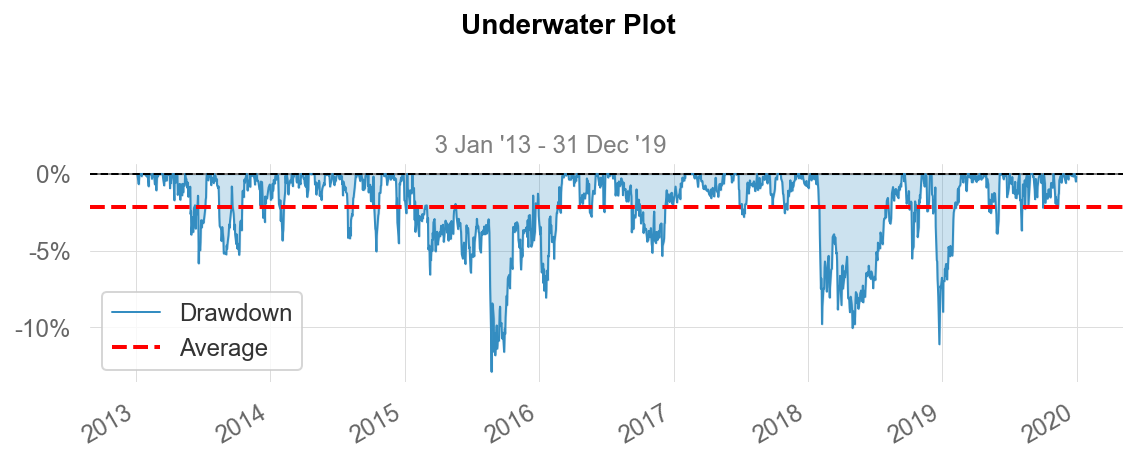

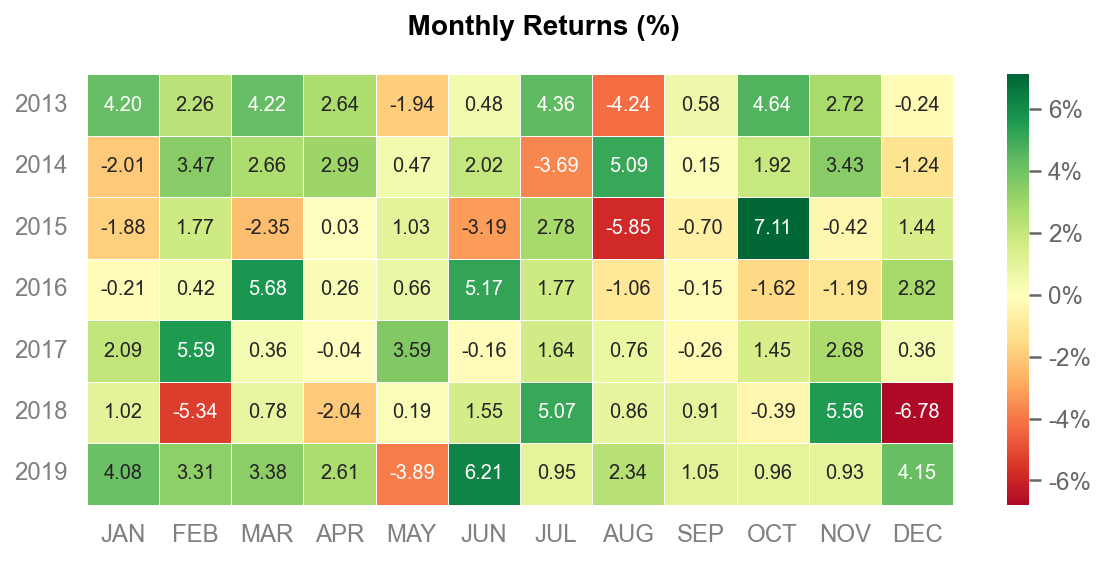

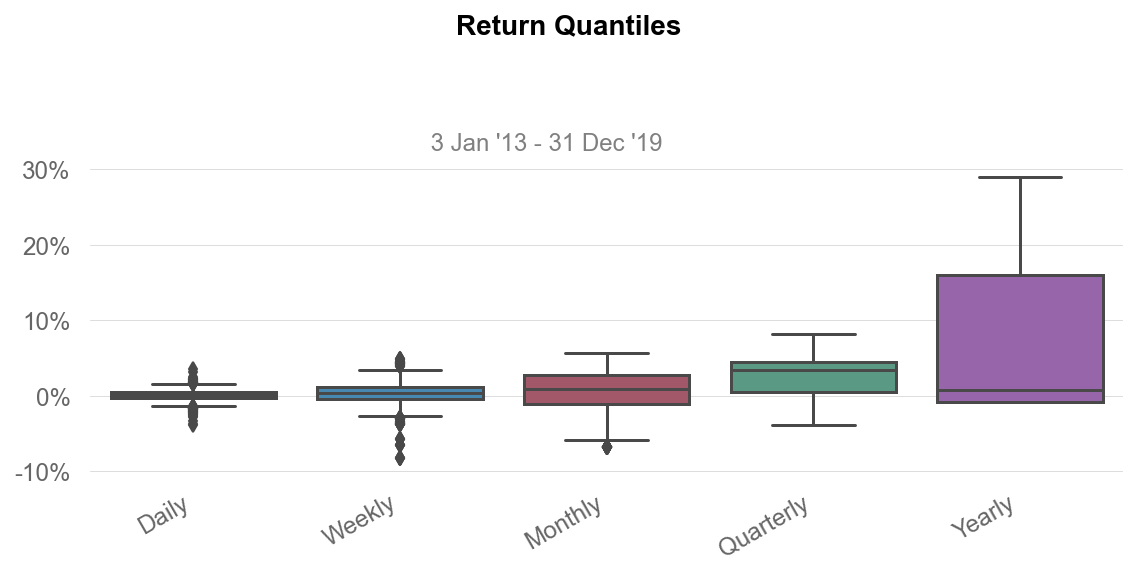

In [140]:
bnch_ret = (bt.ret * bt.w_cap.groupby("permno").shift(1)).groupby("date").sum()
bt_ret = (bt.ret * bt.w_optimal).groupby("date").sum()
qs.reports.full(bt_ret, bnch_ret)